In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-plant-species/house_plant_species/Orchid/208.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/45.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/89.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/212.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/58.JPG
/kaggle/input/house-plant-species/house_plant_species/Orchid/150.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/6.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/109.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/149.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/187.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/76.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/71.JPG
/kaggle/input/house-plant-species/house_plant_species/Orchid/182.jpg
/kaggle/input/house-plant-species/house_plant_species/Orchid/215.jpg
/kaggle/input/house-plant-species/house_p

In [2]:
"""
House Plant Species Prediction - Kaggle Notebook

This script trains a pre-trained EfficientNet-B0 model to classify images of
house plants into different species. It handles data loading, model setup,
training, evaluation, and visualization of results.

The script expects a dataset structured for use with torchvision's ImageFolder,
where each subdirectory in the data directory represents a class.
"""

"\nHouse Plant Species Prediction - Kaggle Notebook\n\nThis script trains a pre-trained EfficientNet-B0 model to classify images of\nhouse plants into different species. It handles data loading, model setup,\ntraining, evaluation, and visualization of results.\n\nThe script expects a dataset structured for use with torchvision's ImageFolder,\nwhere each subdirectory in the data directory represents a class.\n"

In [3]:
# --- Imports ---
import logging
import os
import random
from pathlib import Path
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
from sklearn.metrics import classification_report

In [4]:
# Suppress common warnings from libraries like Matplotlib and PyTorch to keep notebook output clean.
# In a production environment, it's often better to handle specific warnings more granularly.
import warnings
warnings.filterwarnings('ignore')

In [5]:
# --- Configuration ---
class TrainingConfig:
    """
    Configuration class to hold all hyperparameters and settings.
    This avoids "magic numbers" and makes the script easy to modify.
    """
    # Directory and Path Configuration
    DATA_DIR = Path("/kaggle/input/house-plant-species/house_plant_species")
    MODEL_SAVE_PATH = "house_plant_classifier_v1.pth"

    # Data Preprocessing and Loading
    BATCH_SIZE = 32
    TRAIN_SPLIT = 0.8
    VAL_SPLIT = 0.1
    # Note: Test split is calculated as 1.0 - TRAIN_SPLIT - VAL_SPLIT
    NUM_WORKERS = os.cpu_count() or 2

    # Model Architecture
    DROPOUT_RATE = 0.2

    # Training Configuration
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LEARNING_RATE = 1e-3
    EPOCHS = 10
    SEED = 42

In [6]:
# --- Data Loading and Preparation ---
def create_dataloaders(
    data_dir: Path,
    transform: transforms.Compose,
    config: TrainingConfig,
) -> tuple[DataLoader, DataLoader, DataLoader, list[str]]:
    """Creates training, validation, and test DataLoaders from an ImageFolder.

    Args:
        data_dir: Path to the root data directory.
        transform: Torchvision transforms to apply.
        config: The configuration object.

    Returns:
        A tuple of (train_dataloader, val_dataloader, test_dataloader, class_names).
    """
    dataset = ImageFolder(root=data_dir, transform=transform)
    class_names = dataset.classes

    # Data Splitting
    total_size = len(dataset)
    train_size = int(config.TRAIN_SPLIT * total_size)
    val_size = int(config.VAL_SPLIT * total_size)
    test_size = total_size - train_size - val_size

    # Ensure seeding for reproducible splits
    generator = torch.Generator().manual_seed(config.SEED)
    train_data, val_data, test_data = random_split(
        dataset, [train_size, val_size, test_size], generator=generator
    )

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    val_dataloader = DataLoader(
        val_data,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    # Store test_data inside the dataloader for later visualization
    test_dataloader = DataLoader(
        test_data,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    test_dataloader.dataset_unbatched = test_data

    return train_dataloader, val_dataloader, test_dataloader, class_names


In [7]:
# --- Model Architecture ---
def create_efficientnet_b0(
    num_classes: int, config: TrainingConfig
) -> tuple[nn.Module, transforms.Compose]:
    """Creates an EfficientNet-B0 model with a custom classifier head.

    Args:
        num_classes: Number of output classes for the model.
        config: The configuration object.

    Returns:
        A tuple containing the PyTorch model and the appropriate transforms.
    """
    weights = models.EfficientNet_B0_Weights.DEFAULT
    model = models.efficientnet_b0(weights=weights).to(config.DEVICE)

    # Freeze all base layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Recreate the classifier head with a new seed
    torch.manual_seed(config.SEED)
    model.classifier = nn.Sequential(
        nn.Dropout(p=config.DROPOUT_RATE, inplace=True),
        nn.Linear(in_features=1280, out_features=num_classes),
    ).to(config.DEVICE)

    return model, weights.transforms()


In [8]:
# --- Training Engine ---
def train_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    device: str,
) -> tuple[float, float]:
    """Performs a single training step over one epoch.

    Returns:
        A tuple containing the average training loss and accuracy per batch.
    """
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        y_pred = model(images)
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item() / len(y_pred)
    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(
    model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module, device: str
) -> tuple[float, float]:
    """Performs a single testing/validation step over one epoch.

    Returns:
        A tuple containing the average test/validation loss and accuracy per batch.
    """
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            test_pred_logits = model(images)
            loss = loss_fn(test_pred_logits, labels)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == labels).sum().item() / len(test_pred_labels)
    return test_loss / len(dataloader), test_acc / len(dataloader)


def train(
    model: nn.Module,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    config: TrainingConfig,
) -> dict[str, list[float]]:
    """Trains and validates a PyTorch model for a given number of epochs."""
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in tqdm(range(config.EPOCHS)):
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, config.DEVICE
        )
        val_loss, val_acc = test_step(
            model, val_dataloader, loss_fn, config.DEVICE
        )
        # The print statement is kept for immediate feedback in an interactive notebook
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}"
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
    return results


In [9]:
# --- Utility and Evaluation Functions ---
def save_model(model: nn.Module, save_path: str) -> None:
    """Saves the model's state dictionary to a file.

    Args:
        model: The PyTorch model to save.
        save_path: The path where the model will be saved.
    """
    logging.info(f"Saving model to: {save_path}")
    torch.save(obj=model.state_dict(), f=save_path)


def plot_loss_curves(results: dict[str, list[float]]) -> None:
    """Plots training and validation loss and accuracy curves."""
    plt.figure(figsize=(15, 7))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label="train_loss")
    plt.plot(results["val_loss"], label="val_loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.legend()
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results["train_acc"], label="train_accuracy")
    plt.plot(results["val_acc"], label="val_accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()


def evaluate_and_plot_predictions(
    model: nn.Module,
    test_dataloader: DataLoader,
    class_names: list[str],
    device: str
) -> None:
    """Makes predictions on random test samples and visualizes them."""
    # Get random samples
    test_samples, test_labels = [], []
    # Ensure there are enough samples to draw from, otherwise, use all available samples
    num_samples_to_plot = min(9, len(test_dataloader.dataset_unbatched))
    for sample, label in random.sample(list(test_dataloader.dataset_unbatched), k=num_samples_to_plot):
        test_samples.append(sample)
        test_labels.append(label)

    # Make predictions
    model.eval()
    pred_probs = []
    with torch.inference_mode():
        for sample in test_samples:
            sample = sample.unsqueeze(0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    pred_classes = torch.stack(pred_probs).argmax(dim=1)


    # Plot predictions
    plt.figure(figsize=(14, 14))
    plt.suptitle("Model Predictions vs. Truth", fontsize=16)

    for i, sample in enumerate(test_samples):
        plt.subplot(3, 3, i + 1)
        # Tensors need to be on CPU and permuted for matplotlib
        plt.imshow(sample.cpu().permute(1, 2, 0))
        pred_label = class_names[pred_classes[i]]
        truth_label = class_names[test_labels[i]]

        title = f"Pred: {pred_label}\nTruth: {truth_label}"
        plt.title(title, fontsize=9, c="g" if pred_label == truth_label else "r")
        plt.axis(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8519 | train_acc: 0.6029 | val_loss: 1.0878 | val_acc: 0.7646
Epoch: 2 | train_loss: 0.9509 | train_acc: 0.7678 | val_loss: 0.8299 | val_acc: 0.7959
Epoch: 3 | train_loss: 0.7667 | train_acc: 0.8030 | val_loss: 0.7462 | val_acc: 0.8012
Epoch: 4 | train_loss: 0.6652 | train_acc: 0.8225 | val_loss: 0.6849 | val_acc: 0.8125
Epoch: 5 | train_loss: 0.5866 | train_acc: 0.8416 | val_loss: 0.6465 | val_acc: 0.8258
Epoch: 6 | train_loss: 0.5536 | train_acc: 0.8498 | val_loss: 0.6276 | val_acc: 0.8271
Epoch: 7 | train_loss: 0.5130 | train_acc: 0.8583 | val_loss: 0.6358 | val_acc: 0.8245
Epoch: 8 | train_loss: 0.4710 | train_acc: 0.8690 | val_loss: 0.6202 | val_acc: 0.8285
Epoch: 9 | train_loss: 0.4549 | train_acc: 0.8720 | val_loss: 0.6107 | val_acc: 0.8258
Epoch: 10 | train_loss: 0.4358 | train_acc: 0.8756 | val_loss: 0.6232 | val_acc: 0.8185

--- CLASSIFICATION REPORT (Test Set) ---
                                            precision    recall  f1-score   support

  

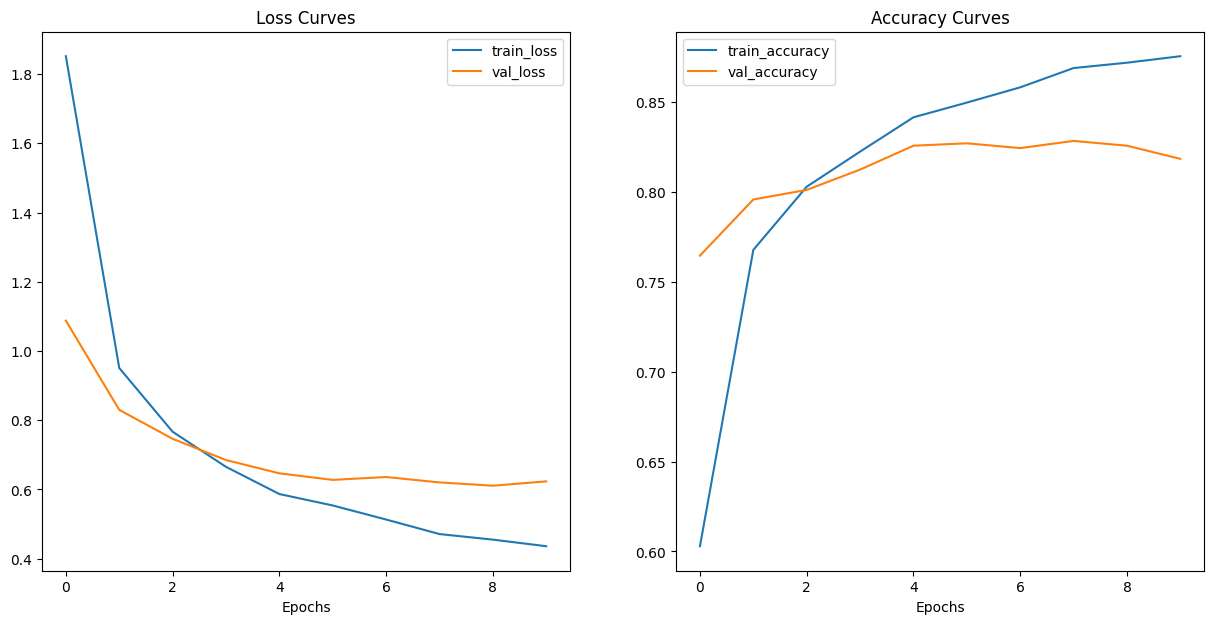

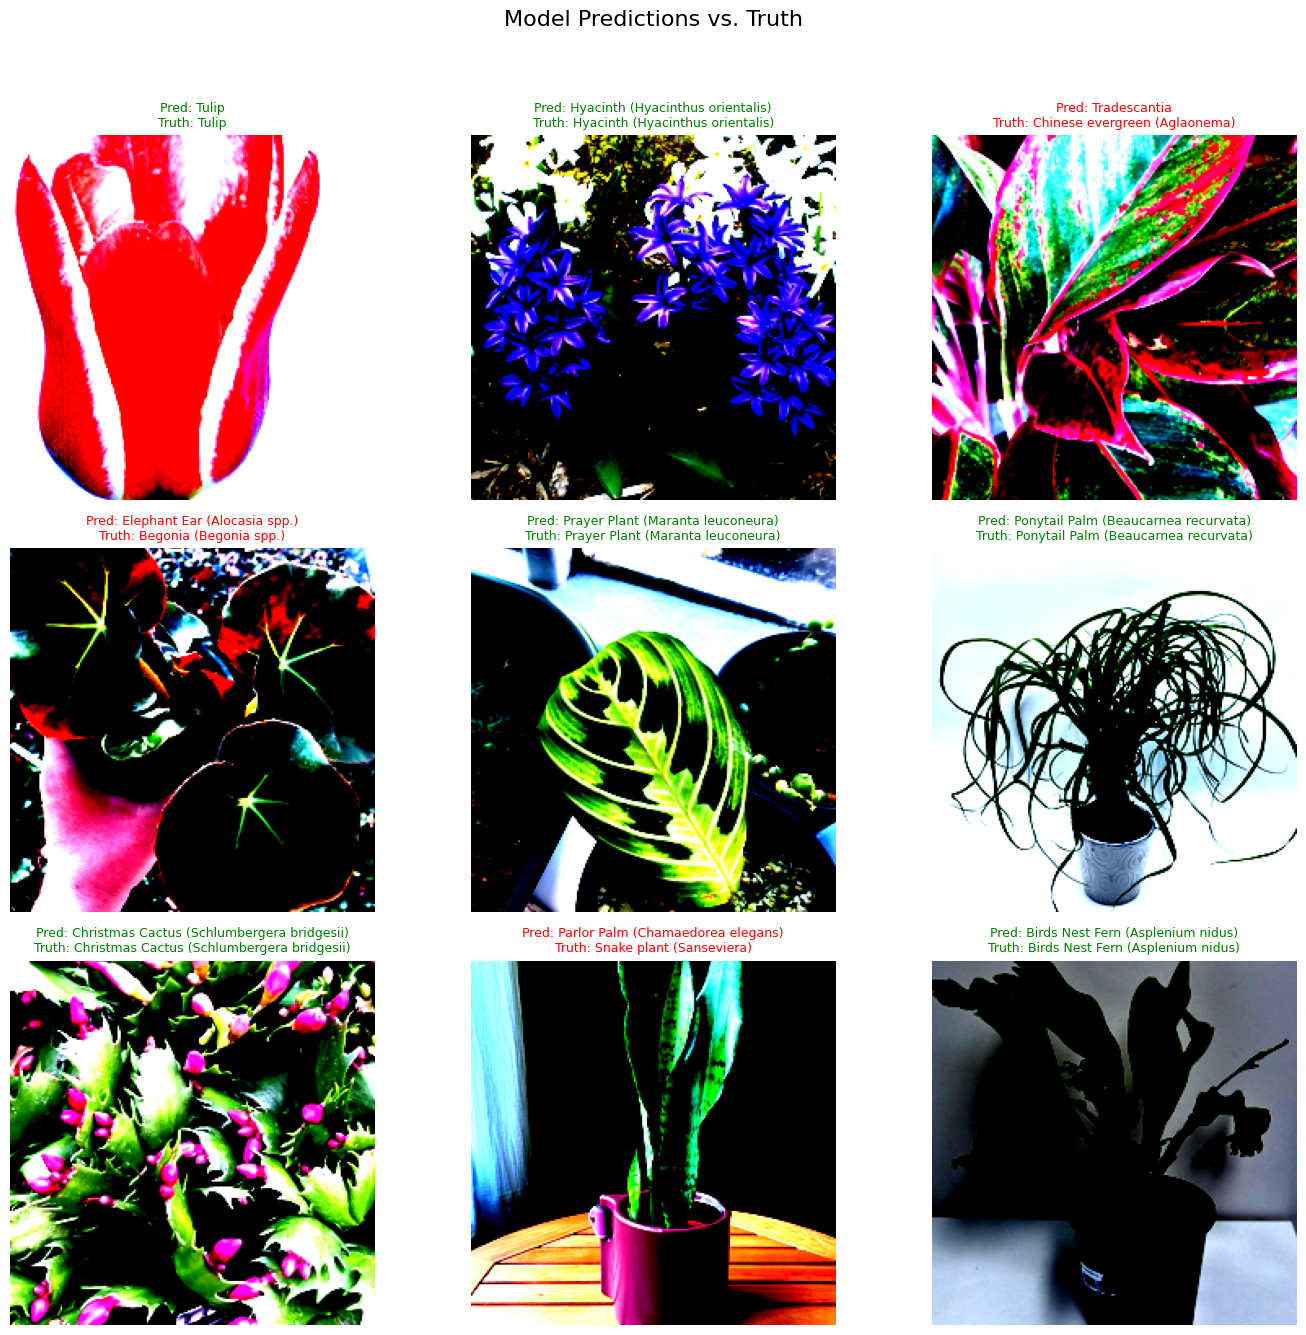

In [10]:
# --- Main Execution Block ---
def main():
    """Main function to orchestrate model training and evaluation."""
    # Setup logging
    logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")

    # Initialize configuration
    config = TrainingConfig()
    logging.info(f"Using device: {config.DEVICE}")
    logging.info(f"Using seed: {config.SEED}")

    # Set seeds for reproducibility
    torch.manual_seed(config.SEED)
    torch.cuda.manual_seed(config.SEED)

    # The pretrained model defines its own transforms. We must get them this way.
    dummy_num_classes = 10
    _, auto_transforms = create_efficientnet_b0(dummy_num_classes, config)
    logging.info(f"Applying transforms: {auto_transforms}")

    # Create DataLoaders
    train_dl, val_dl, test_dl, class_names = create_dataloaders(
        data_dir=config.DATA_DIR, transform=auto_transforms, config=config
    )
    logging.info(f"Found {len(class_names)} classes.")
    logging.info(f"Train batches: {len(train_dl)}, Val batches: {len(val_dl)}, Test batches: {len(test_dl)}")

    # Re-create the model with the correct number of classes
    model, _ = create_efficientnet_b0(len(class_names), config)
    summary(
        model,
        input_size=(config.BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
    )

    # Train the model
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

    start_time = timer()
    results = train(model, train_dl, val_dl, optimizer, loss_fn, config)
    end_time = timer()
    logging.info(f"Total training time: {end_time - start_time:.3f} seconds")

    # Save the trained model
    save_model(model=model, save_path=config.MODEL_SAVE_PATH)

    # --- NEW CODE TO ADD FOR CLASSIFICATION REPORT ---
    logging.info("Starting final evaluation on test data...")

    # Ensure model is in evaluation mode
    model.eval()
    
    # Collect all predictions and true labels from the test_dl
    y_true_all = []
    y_pred_all = []

    with torch.inference_mode():
        for X_batch, y_batch in test_dl:
            X_batch, y_batch = X_batch.to(config.DEVICE), y_batch.to(config.DEVICE)
            y_logit = model(X_batch)
            y_pred_prob = torch.softmax(y_logit, dim=1)
            y_pred_label = torch.argmax(y_pred_prob, dim=1)

            y_true_all.extend(y_batch.cpu().numpy())
            y_pred_all.extend(y_pred_label.cpu().numpy())

    # Generate and print classification report
    # Ensure class_names are correctly loaded/available (they should be from create_dataloaders)
    from sklearn.metrics import classification_report # Import within main if not at top

    print("\n--- CLASSIFICATION REPORT (Test Set) ---")
    print(classification_report(y_true=y_true_all, y_pred=y_pred_all, target_names=class_names))
    print("---------------------------------------")
    logging.info("Finished test data evaluation.")
    # --- END NEW CODE ---

    # Evaluate the model with plots
    plot_loss_curves(results)
    evaluate_and_plot_predictions(model, test_dl, class_names, config.DEVICE)

    # Save the class names for use in the Flask app
    logging.info("Saving class names to class_names.txt")
    with open("class_names.txt", "w") as f:
        for plant_name in class_names:
            f.write(f"{plant_name}\n")
    logging.info("class_names.txt saved successfully.")


if __name__ == "__main__":
    main()